(page:xrd)=
# (Powder) X-Ray Diffraction Spectra

This script uses published scattering coefficients in combination with Debye's equation to predict the powder XRD spectrum for a given input structure in the `.bgf` file format. A number of different incidence wave lengths can be chosen and the simulated range of incidence angles can be adjusted easily. 

Similar to the [RDF analysis](page:rdf), the Pt-Pt pairs of the pristine octahedral particle analyzed here show pronounced long-range ordering. Once again we encourage changing the input structure by adjusting `n_O` to observe how the XRD feature become less distinct and the background increases as the particle becomes more amorphous as a function of oxidation.

Here, we choose a $\mathrm{Cu-K}_{\alpha}$ source for the incidence wave length and vary the incidence angle between 7.5° and 42.5° in 0.1° increments. Change these parameters to observe the impact on the produced spectrum.

Start by reading in the data.

In [17]:
import pandas as pd

data = pd.read_csv("../data/data.csv")

Choose a clean system with 0 oxygen atoms.

In [18]:
from asetools.systemtools import read_bgf

sample = data.loc[(data["n_O"] == 0)].iloc[0]
atoms = read_bgf(sample["root"])

We will pre-define lookup tables for later use. First, we define a `dictionary` containing atomic scattering factors for Pt and O obtained from [Cromer, Mann Acta Cryst A24 321-324 (1968)](https://scripts.iucr.org/cgi-bin/paper?s0567739468000550). 

In [19]:
fdict = {'Pt':[36.8102, 13.0747, 11.3323, 2.31421, 1.04422,
               6.07340, 15.7018, 73.8375, 14.4526],
         'O':[2.95648, 2.45240, 1.50510, 0.78135, 13.8964,
              5.91765, 0.34537, 34.0811, 0.30413]}

Next, define a `dictionary` object with various incidence radiation wave lengths. For now we choose $\mathrm{Cu-K}_{\alpha}$ radiation but change the selector below to simulate any other wave length.

In [20]:
wldict = {'Cr': 2.29100, 'Fe': 1.93736, 'Co': 1.79026, 'Cu': 1.54184,
          'Mo': 0.71073}
wavelength = wldict['Cu']

Next, set up some key parameters for the spectrum generation. You may need to modify `thetaMin` and `thetaMax` if you choose a different incidence wave length above.

In [21]:
thetaMin = 7.5  # Smallest incidence angle to be calculated.
thetaMax = 42.5 # Largest incidence angle to be calculated.
thetaInc =  0.1 # Increment of steps from thetaMin to thetaMax.
I0 = 0.00001    # Incidence radiation intensity.

`I0` is a somewhat arbitrary value that controls the magnitude of the scattered intensity bands. It does not change the peak positions or peak width, just the scaling of the $y$ axis.

The following steps are similar to the [radial distribution function](page:rdf) implementation. First, we need to calculate distances for all atomic pairs. 

There is one key difference compared to the RDF implementation: the code needs to remember the elements of the atom pair for each calculated distance. The reason is that the scattering factors that enter Debye's equation together with the distances are element-specific. Fortunately, `ase.Atoms.get_all_distances` makes it easy for us to connect the distances with the atoms they were calculated from. This function yields an array of size `len(atoms)` where each entry is another array that also has size `len(atoms)`. In other words, the distance arrays are always in the same order as the `ase.Atoms` object that they were generated from.

In [22]:
dists = atoms.get_all_distances()

To illustrate the ordering of the array, let's select the distance of atom 5 and atom 76.

In [23]:
print("The distance between atoms 5 and 76 is ", (dists[5][76]), "Å")

The distance between atoms 5 and 76 is  10.820770135189084 Å


Remember that you can pass `mic = True` to this function to make it take periodic boundary conditions into account. Otherwise, if you attempt to calculate the powder XRD spectrum of a bulk crystal, it will be erroneously treated as a small cluster instead.

We mentioned the caveats of the `atoms.Atoms.get_all_distances` function before for the [RDF analysis](page:rdf). First, it calculates distances for the same pair twice, from atom1 to atom2 and the other way around. Hence, we there is a separate entry for the distance between atom 76 and atom 5 which is identical to the value generated above:

In [24]:
print("The distance between atoms 76 and 5 is ", (dists[76][5]), "Å")

The distance between atoms 76 and 5 is  10.820770135189084 Å


Second, the function calculates self-interaction distances of atoms with themselves. We can see that this is the case by selecting atom 5 twice in the `dists` output array-of-arrays:

In [25]:
print("The distance between atoms 5 and 5 is ", (dists[5][5]), "Å")

The distance between atoms 5 and 5 is  0.0 Å


We will need to keep these limitations in mind when evaluating the distances below. 

In order to implement the rest of the function in an efficient way, it is useful to first look at a pseudocode flow chart of what needs to happen next.

* Loop over `thetaInc` from `thetaMin` to `thetaMax`.
    * Loop over all pairs of atoms.
        * Calculate $\Theta$-dependent scattering factors for each element in current pair.
        * Calculate $\Theta$-dependent Debye equation for current pair.

Analyzing this pseudocode, it becomes clear that calculating the scattering factors for each element in each pair is not necessary. The scattering factors only depend on the incidence angle $\Theta$ and the element. We can therefore pre-calculate the scattering factors for the entire range of `theta` into a lookup `dictionary` and then recall these values as we loop through the pairs.

Define the `theta` range to loop over.      

In [26]:
thetaRange = []
theta = thetaMin
while theta <= thetaMax:
    thetaRange.append(theta)
    theta += thetaInc

Define a function we can call to calculate the scattering factors. Note the conversion from degrees to radians for the incidence angle `theta`.

In [27]:
import numpy as np

def calcSF(element, thetaRange, wl):
    """Calculate scattering factors for the supplied element."""
    sf = []
    a1, a2, a3, a4, b1, b2, b3, b4, c = fdict[element]
    for theta in thetaRange:
        rtheta = np.radians(theta)
        sinDvLa = ((np.sin(rtheta) * np.sin(rtheta)) / (wl * wl))
        f = (a1 * np.exp((-1 * b1 * sinDvLa)))
        f += (a2 * np.exp((-1 * b2 * sinDvLa)))
        f += (a3 * np.exp((-1 * b3 * sinDvLa)))
        f += (a4 * np.exp((-1 * b4 * sinDvLa)))
        f += c
        sf.append(f)
        
    return sf

Pre-calculate scattering factors for all elements and incidence angles `theta`.

In [28]:
scattering_factors = {}
for unique_element in set(atoms.get_chemical_symbols()):
    sflist = calcSF(unique_element, thetaRange, wavelength)
    scattering_factors.update({unique_element: sflist})

We can now calculate Debye's equation which is defined as

$I(\theta) = I_0\ \sum_{i,j}\ f_i\ f_j\ \frac{\sin(d\ r_{ij})}{d\ r_{ij}}$,

where $I(\theta)$ is the scattered intensity at angle $\theta$, $i$ and $j$ are atomic indices, $f_i$ and $f_j$ are the atomic scattering factors for atoms $i$ and $j$, $d$ is the diffracted wave vector, and $r_{ij}$ are the distances between atoms $i$ and $j$.

The diffracted wave vector $d$ is defined as

$d = \frac{4 \pi\ \sin(\theta)}{\lambda}$,

where $\lambda$ is the incidence radiation wave length. Note that $\theta$ in this formula refers to the incidence angle in radians and not in degrees. A conversion is thus necessary.

In [29]:
spectrum = {}
for t, theta in enumerate(thetaRange):
    rtheta = np.radians(theta)

    # Calculate diffracted wave vector d.
    d = 4.0 * np.pi * np.sin(rtheta) / wavelength

    # Calculate Debye's equation.
    Itheta = 0.0
    for i, dlist in enumerate(dists[:-1]):
        f_i = scattering_factors[atoms[i].symbol][t]
        for j, rij in enumerate(dlist[i + 1:]):
            f_j = scattering_factors[atoms[j].symbol][t]
            Itheta += (f_i * f_j * np.sin(d * rij) / (d * rij))

    # Multiply with incidence radiation intensity to get scattered
    # intensity I(theta).
    Itheta *= I0
    spectrum.update({theta: Itheta})

Let's break down this complex loop. We `enumerate` the `thetaRange` list because we know that its length correlates 1:1 with the length of the `theta`-dependent scattering factor lists for the elements which we select by `scattering_factors[atoms[i].symbol]`.

Also, we know that `ase.Atoms.get_all_distances` creates duplicates for both distance(atom1, atom2) and distance(atom2, atom1). Because we know that `dists` and its sub-arrays, selected here as `dlist`, have the same ordering as the atoms object, we can use slicing to make sure we don't get any duplicates when going through `dists` and `dlist`. This approach is similar to what was discussed for the first, numerically slow implementation of the distance calculation for the [RDF analysis](page:rdf).

```{tip} Executing the above cell is numerically taxing and took over 2 mins on my 11th gen i7 CPU. Of course, there are ways to get around using nested for loops in this case as well using numpy broadcasting operations. However, the vectorized solution to this problem is beyond the scope of this tutorial. See for example the [implementation of this XRD code in asetools](https://gitlab.com/bjk24/asetools/-/blob/main/asetools/analysis/xrd.py) for inspiration. But beware - by removing for loops and building big numpy arrays to do broadcasting operations with, we can reduce the CPU load but we also increase memory requirements by a lot. This is the trade-off with code vectorization, as evidenced by the extreme hunger for memory of (tensor-based) machine learning models.
```

Finally, we can visualize the resulting spectrum. `dictionary.items` returns a list of (key, value) tuples, which we can split into two separate lists of only keys and only values for the purpose of passing it to `pyplot`.

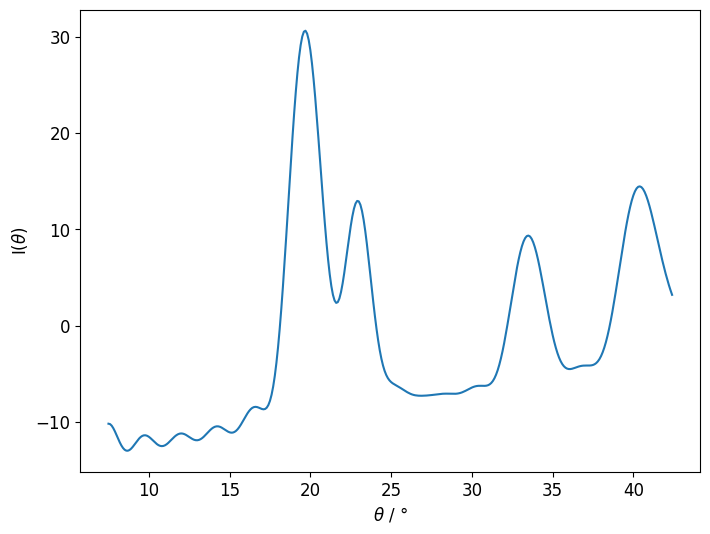

In [30]:
import matplotlib.pyplot as plt

x, y = zip(*spectrum.items())
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 12})
plt.plot(x, y)
plt.xlabel("$\\theta$ / °")
plt.ylabel("I($\\theta$)")
plt.show()